In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LogNorm

import numpy as np
import qutip as qt

from scipy import special, optimize
from scipy.interpolate import CubicSpline

from collections import Counter
import os

In [2]:
delta = -1
beta = 1

In [3]:
Ap = (1 / 2 + 1 / 2 * (1 + 4 / 27 * (delta / beta) ** 3) ** (1 / 2)) ** (1 / 3)
Am = (1 / 2 - 1 / 2 * (1 + 4 / 27 * (delta / beta) ** 3) ** (1 / 2)) ** (1 / 3)
x1 = (Ap + Am) * np.exp(1j * np.pi / 4)
x2 = ((Ap * np.exp(-1j * np.pi / 6) - Am * np.exp(1j * np.pi / 6))
      * np.exp(-1j * np.pi / 4))
x3 = ((Ap * np.exp(1j * np.pi / 6) - Am * np.exp(-1j * np.pi / 6))
      * np.exp(3 * 1j * np.pi / 4))
a1 = x1 / ((x1 - x2) * (x1 - x3))
a2 = x2 / ((x2 - x1) * (x2 - x3))
a3 = x3 / ((x3 - x2) * (x3 - x1))
y1 = (x1**2) ** (1 / 2)
y2 = (x2**2) ** (1 / 2)
y3 = (x3**2) ** (1 / 2)


def c(t):
    return (
        2 * x1 * a1 * np.exp((beta * x1**2 + 1j * delta) * t)
        + a2 * (x2 + y2) * np.exp((beta * x2**2 + 1j * delta) * t)
        - (a1 * y1 * (1 - special.erf((beta * x1**2 * t) ** (1 / 2)))
           * np.exp((beta * x1**2 + 1j * delta) * t))
        - (a2 * y2 * (1 - special.erf((beta * x2**2 * t) ** (1 / 2)))
           * np.exp((beta * x2**2 + 1j * delta) * t))
        - (a3 * y3 * (1 - special.erf((beta * x3**2 * t) ** (1 / 2)))
           * np.exp((beta * x3**2 + 1j * delta) * t))
    )


def cd(t):  # time derivative
    return (
        ((beta * x1**2 + 1j * delta) * 2 * x1 * a1
         * np.exp((beta * x1**2 + 1j * delta) * t))
        + ((beta * x2**2 + 1j * delta) * a2 * (x2 + y2)
           * np.exp((beta * x2**2 + 1j * delta) * t))
        - ((beta * x1**2 + 1j * delta) * a1 * y1
           * (1 - special.erf((beta * x1**2 * t) ** (1 / 2)))
           * np.exp((beta * x1**2 + 1j * delta) * t))
        - ((beta * x2**2 + 1j * delta) * a2 * y2
           * (1 - special.erf((beta * x2**2 * t) ** (1 / 2)))
           * np.exp((beta * x2**2 + 1j * delta) * t))
        - ((beta * x3**2 + 1j * delta) * a3 * y3
           * (1 - special.erf((beta * x3**2 * t) ** (1 / 2)))
           * np.exp((beta * x3**2 + 1j * delta) * t))
        + (a1 * y1 * x1 * np.exp(-beta * t * x1**2)
           * (beta / (t * np.pi + 0.00001)) ** (1 / 2)
           * np.exp((beta * x1**2 + 1j * delta) * t))
        + (a2 * y2 * x2 * np.exp(-beta * t * x2**2)
           * (beta / (t * np.pi + 0.00001)) ** (1 / 2)
           * np.exp((beta * x2**2 + 1j * delta) * t))
        + (a3 * y3 * x3 * np.exp(-beta * t * x3**2)
           * (beta / (t * np.pi + 0.00001)) ** (1 / 2)
           * np.exp((beta * x3**2 + 1j * delta) * t))
    )


def S(t):
    return -2 * np.imag(cd(t) / c(t))


def Gamma(t):
    return -2 * np.real(cd(t) / c(t))

In [4]:
ti = optimize.root_scalar(Gamma, bracket=(1.4, 1.5)).root
duration = 10
steps = 100

times = np.linspace(ti, ti + duration, steps + 1)

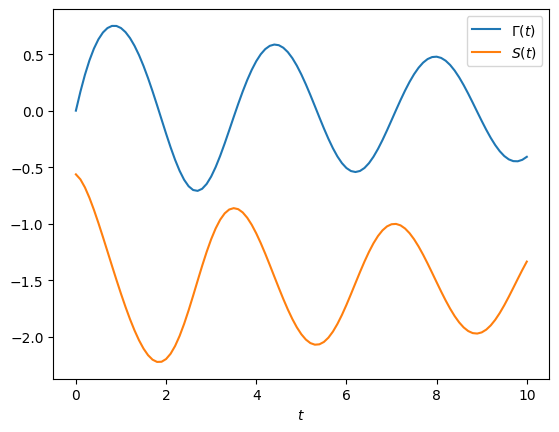

In [5]:
Gamma_values = Gamma(times)
S_values = S(times)

plt.plot(times - ti, Gamma_values, label=r"$\Gamma(t)$")
plt.plot(times - ti, S_values, label=r"$S(t)$")
plt.xlabel(r"$t$")
plt.legend()
plt.show()

In [6]:
Gamma_int = CubicSpline(times, np.complex128(Gamma_values))
S_int = CubicSpline(times, np.complex128(S_values))

In [7]:
nmmc_options = {"map": "parallel",
                "norm_steps": 10}  # options specific to nm_mcsolve
options = {"progress_bar": "enhanced"}  # options shared by all solvers
ntraj = 5500

H = 2 * qt.sigmap() * qt.sigmam()
ops_and_rates = [[qt.sigmam(), Gamma_int]]
psi0 = qt.basis(2, 0)
e_ops = [H]

In [8]:
solver = qt.NonMarkovianMCSolver(qt.QobjEvo([H, S_int]),
                                 ops_and_rates,
                                 options=(options | nmmc_options))

for L in solver.ops:
    print(L, "\n")

completeness_check = sum(L.dag() * L for L in solver.ops)
with qt.CoreOptions(atol=1e-5):
    assert completeness_check == qt.qeye(2)

MCSol = solver.run(psi0, tlist=times, ntraj=ntraj, e_ops=e_ops)

d_ops = [[qt.lindblad_dissipator(qt.sigmam(), qt.sigmam()), Gamma]]
MESol = qt.mesolve([H, S], psi0, times, d_ops, e_ops, options=options)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]] 

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]] 

 Total run time:  48.05s*] Elapsed 47.15s / Remaining 00:00:00:00          1%           ] Elapsed 4.75s / Remaining 00:00:07:50[          1%           ] Elapsed 4.91s / Remaining 00:00:08:06[          1%           ] Elapsed 4.96s / Remaining 00:00:08:10[          2%           ] Elapsed 5.53s / Remaining 00:00:04:31[*         3%           ] Elapsed 5.60s / Remaining 00:00:03:00[*         3%           ] Elapsed 5.79s / Remaining 00:00:03:07[*         4%           ] Elapsed 6.24s / Remaining 00:00:02:29[*         4%           ] Elapsed 6.40s / Remaining 00:00:02:33[*         5%           ] Elapsed 6.74s / Remaining 00:00:02:08[*         6%           ] Elapsed 6.86s / Remaining 00:00:01:47[*         6%           ] Elapsed 6.90s / Remaining 00:00:01:48[*      

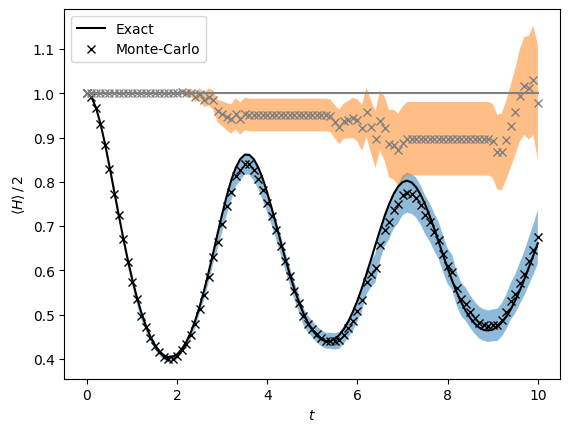

In [9]:
plt.plot(times - ti, MESol.expect[0] / 2, "k-", label="Exact")
plt.plot(times - ti, MCSol.expect[0] / 2, "kx", label="Monte-Carlo")
plt.fill_between(
    times - ti,
    (MCSol.expect[0] - MCSol.std_expect[0] / np.sqrt(ntraj)) / 2,
    (MCSol.expect[0] + MCSol.std_expect[0] / np.sqrt(ntraj)) / 2,
    alpha=0.5,
)

plt.plot(times - ti, np.ones_like(times), "-", color="0.5")
plt.plot(times - ti, MCSol.trace, "x", color="0.5")
plt.fill_between(
    times - ti,
    MCSol.trace - MCSol.std_trace / np.sqrt(ntraj),
    MCSol.trace + MCSol.std_trace / np.sqrt(ntraj),
    alpha=0.5,
)

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle H \rangle\, /\, 2$")
plt.legend()
plt.show()

In [10]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from mpmath import *
from qutip.solver.nonmarkov.transfertensor import ttmsolve
from scipy.ndimage import gaussian_filter1d



In [11]:
lam = 0.05
gamma_0 = 0.2

def Expr(t):
    l = np.emath.sqrt(lam**2 - 2*gamma_0*lam)

    expression = ((-l**2 + lam**2)*np.sinh(l*t/2))/(l*np.cosh(l*t/2) + lam*np.sinh(l*t/2))

    return expression

def s(t):
    return np.imag(Expr(t))

#Define Hamiltonian

H0 = sigmam()*sigmap()

# Define gammma(t)

# def gam(t):
#     if np.real(Expr(t)) < 0 :
#         return np.sqrt(complex(np.real(Expr(t))))
#     else:
#         return np.sqrt(np.real(Expr(t)))       #np.sqrt(np.real(Expr(t)))

def gam(t):
    return np.real(Expr(t))


time = np.linspace(0.1, 200, 100)  # Adjust time range as needed

# Calculate gam values
gam_vals = np.array([gam(t) for t in time])



def smoothen_gamma(gamma_vals, sigma=2):
    """
    Smoothen the gamma(t) values using a Gaussian filter.

    Parameters:
    gamma_vals (np.array): The input array of gamma(t) values.
    sigma (float): The standard deviation for Gaussian kernel. Higher values result in more smoothing.
    
    Returns:
    np.array: The smoothened gamma(t) array.
    """
    # Apply Gaussian filter for smoothing
    smoothened_gamma = gaussian_filter1d(gamma_vals, 2)
    return smoothened_gamma

gam_vals_new = smoothen_gamma(gam_vals)



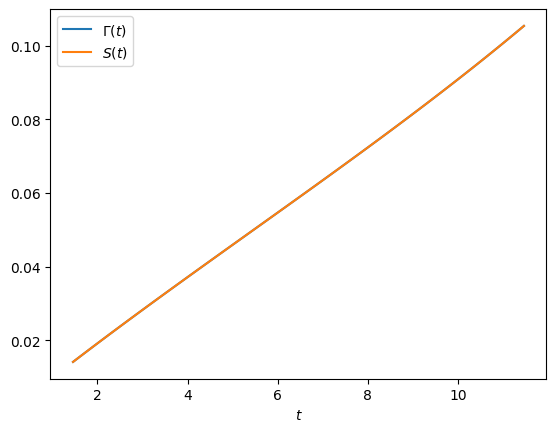

In [16]:
gam_values = gam(times)
S_values = s(times)


plt.plot(times, gam_values, label=r"$\Gamma(t)$")
plt.plot(times, gam_vals, label=r"$S(t)$")
plt.xlabel(r"$t$")
plt.legend()
plt.show()